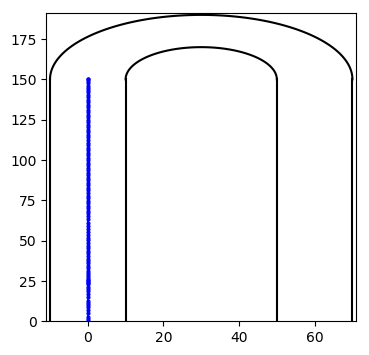


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



In [5]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt

## Tyre specs
coflo = 0.5
5 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.7 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)

## car specs
mass = 1000 # in kg
g = 12  #km/hr^2
maxacc = 20 # max acc in km/hr^2
maxv = 200 # max velocity in km/hr
maxTu = 1.27 #max steer one side

k = 100 # number of waypoints

m = Model(solver = IpoptSolver(print_level=0))

## Basic variables and their constraints
@variable(m, P[1:2,1:k])  # resulting position in x,y
@variable(m, 0 <= v[1:2,1:k] <= maxv)  # vector resulting velocity
@variable(m, 0 <= Thrust[1:k] <= maxacc)  # thruster input
@variable(m, 0 <= Braking[1:k] <= maxacc)  # braking input
@variable(m, Acc[1:2,1:k]) #Acc[1] is in direction of motion not in x direction, Acc[2] is in direction perpendicular to direction of motion                                   
@constraint(m, Acc[2,1:k] .>= -cofla*g)
@constraint(m, Acc[2,1:k] .<= cofla*g)

## Track boundaries variables and constraints
# TODO:plot track
# @constraint(m, -10 .<= P[1,:] .<= 70)
# for t in 1:k
#     @NLconstraint(m, P[2,t] <= 150 + sqrt(40^2 - P[1,t]^2))
# end

## Start ad Finish constraints
startPos = [0,0]
finishPos = [0,150]
@constraint(m, P[:,1] .== startPos)
@constraint(m, P[:,k] .== finishPos)
@NLexpression(m, finishDistance, sqrt(sum((P[i,k]-finishPos[i])^2 for i in 1:2)))
@constraint(m, v[:,1] .== [0,1])
@constraint(m, v[:,k] .== [0,0])

## motion constraints
for t in 1:k-1
    @NLconstraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * v[1,t]/sqrt(v[1,t]^2+v[2,t]^2))  #     @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t] * cos(atan(v[2,t]/v[1,t])))
    @NLconstraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * v[2,t]/sqrt(v[1,t]^2+v[2,t]^2))   #     @constraint(m, v[2,t+1] == v[2,t] + Acc[1,t] * sin(atan(v[2,t]/v[1,t])))
#     @constraint(m, v[1,t+1] == v[1,t] + Acc[2,t] * cos(atan(v[2,t]/v[1,t])+(3.14/2)))  # turning
#     @constraint(m, v[2,t+1] == v[2,t] + Acc[2,t] * sin(atan(v[2,t]/v[1,t])+(3.14/2)))  # turning
    @NLconstraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*Acc[1,t]*v[1,t]/sqrt(v[1,t]^2+v[2,t]^2))  #     @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*cos(atan(v[2,t]/v[1,t])))
    @NLconstraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*Acc[1,t]*v[2,t]/sqrt(v[1,t]^2+v[2,t]^2))  #     @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*sin(atan(v[2,t]/v[1,t])))
    @constraint(m, Acc[1,t+1] == Acc[1,t] + Thrust[t] - Braking[t] - (coflo*g))
end
@NLobjective(m, Min, finishDistance)
# @objective(m, Min, sum(Thrust))
solve(m)
rad = linspace(0,π,100) 

x = 30 + 40*cos.(rad)
y = 150 +40*sin.(rad)
x1 = 30 + 20*cos.(rad)
y1 = 150 +20*sin.(rad)


Llinex = [-10, -10]
Lliney = [0, 150]
LMlinex = [10,10]
LMliney = [0,150]
RMlinex = [50, 50]
RMliney = [0,150]
Rlinex = [70,70]
Rliney = [0,150]

figure(figsize=(4,4))

plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )

plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
axis([-11,71,0,191]);
# figure(figsize=(12,4))
# plot( getvalue(v[1,:]), "b-", markersize=12 )
# figure(figsize=(12,4))
# plot( getvalue(v[2,:]), "b-", markersize=12 )
# figure(figsize=(12,4))
# plot( getvalue(Acc[1,:]), "b-", markersize=12 )
# # figure(figsize=(12,4))
# # plot( getvalue(Acc[2,:]), "b-", markersize=12 )
# figure(figsize=(12,4))
# plot( getvalue(Thrust), "b-", markersize=12 )
# figure(figsize=(12,4))
# plot( getvalue(Braking), "b-", markersize=12 )